

Pulmonary fibrosis is a medical condition that affects the lungs, causing scarring (fibrosis) to develop within the lung tissue. This scarring can make it difficult for the lungs to function properly, leading to symptoms such as shortness of breath, coughing, and fatigue.

Diagnosis of pulmonary fibrosis often involves a variety of tests, including pulmonary function tests (PFTs), imaging tests such as chest X-rays or CT scans, and sometimes a lung biopsy.

One of the key measurements taken during PFTs is the Forced Vital Capacity (FVC), which measures the amount of air that a person can exhale forcefully after taking a deep breath. In people with pulmonary fibrosis, FVC values tend to decrease as the disease progresses, indicating worsening lung function.

Doctors can use these FVC measurements to track the progression of the disease over time and to monitor the effectiveness of treatments. In addition to FVC, other measures such as diffusing capacity of the lungs for carbon monoxide (DLCO) and oxygen saturation levels may also be used to help diagnose and monitor pulmonary fibrosis.


**OUR CODE AIMS AT EASING OUT THIS COMPLEX PROCEDURE THROUGH FEATURE ENGINEERING**

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model, ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf

from tqdm.notebook import tqdm

import os
from PIL import Image

This code imports several Python libraries that will be used in the code that follows:

- `numpy` (imported as `np`) is a popular library for working with arrays and matrices of numerical data.
- `pandas` (imported as `pd`) is a library for working with data in tabular format.
- `matplotlib.pyplot` (imported as `plt`) is a library for creating visualizations in Python.
- `sklearn.linear_model` and `sklearn.ensemble` are modules from the scikit-learn library, which provides tools for machine learning in Python.
- `sklearn.metrics` provides various metrics to evaluate machine learning models.
- `tensorflow` (imported as `tf`) is a popular library for building and training neural networks and other machine learning models.
- `tqdm.notebook` provides a progress bar to track the progress of lengthy computations in Jupyter notebooks.
- `os` is a built-in Python module that provides a way to interact with the operating system.
- `PIL.Image` is a module from the Pillow library, which provides tools for working with images in Python.

This code only imports the libraries and does not perform any actual tasks. It sets up the environment with necessary tools to perform tasks later in the code.

## Load data

Let's begin by loading the data.

In [ ]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
submission = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')

In [ ]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


In [ ]:
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        5 non-null      object 
 1   Weeks          5 non-null      int64  
 2   FVC            5 non-null      int64  
 3   Percent        5 non-null      float64
 4   Age            5 non-null      int64  
 5   Sex            5 non-null      object 
 6   SmokingStatus  5 non-null      object 
dtypes: float64(1), int64(3), object(3)
memory usage: 408.0+ bytes


So there's not a huge volume of tabular data. 1.5k of training examples with only 5 columns (weeks, percent, age, sex, smoking status) to construct features from.

## Merge datasets

To ensure uniformity in applying transformations to all examples, we combine the train, validation, and test sets. Initially, we confirm the absence of any duplicates in the training dataset.

In [ ]:
train.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])

This code snippet uses the `drop_duplicates()` method of a Pandas DataFrame object to remove duplicate rows from the dataframe `train`. Specifically, it removes rows that have the same values in both the "Patient" and "Weeks" columns.

The `keep=False` parameter ensures that all duplicates are removed (i.e., not just the first or last occurrence of each duplicated value).

The `inplace=True` parameter modifies the `train` dataframe directly, rather than returning a new dataframe.

Overall, this code is likely used to preprocess data for a machine learning task, ensuring that each patient and week combination in the data is unique and preventing any duplicated data from influencing the training of the model.

Then form the submission dataset. The test dataset needs expanding out across the 146 weeks per patient that the competition requires. This can be achieved by joining it to the sample submission.

In [ ]:
submission['Patient'] = (
    submission['Patient_Week']
    .apply(
        lambda x:x.split('_')[0]
    )
)

submission['Weeks'] = (
    submission['Patient_Week']
    .apply(
        lambda x: int(x.split('_')[-1])
    )
)

submission =  submission[['Patient','Weeks', 'Confidence','Patient_Week']]

submission = submission.merge(test.drop('Weeks', axis=1), on="Patient")

This code snippet manipulates a Pandas DataFrame object `submission` and merges it with another DataFrame object `test`. Here's a step-by-step breakdown of what the code is doing:

1. The code creates a new column called "Patient" in the `submission` DataFrame, by applying a lambda function to the "Patient_Week" column. The lambda function splits each value in the "Patient_Week" column on the underscore character, and returns the first part of the split string, which is the patient ID. This effectively extracts the patient ID from the "Patient_Week" column.
2. The code creates another new column called "Weeks" in the `submission` DataFrame, by applying another lambda function to the "Patient_Week" column. This lambda function splits each value in the "Patient_Week" column on the underscore character, and returns the last part of the split string as an integer, which represents the week number.
3. The code then selects a subset of columns from the `submission` DataFrame in the order of "Patient", "Weeks", "Confidence", and "Patient_Week", and assigns it back to the `submission` DataFrame. This effectively reorders the columns and drops any columns that are not needed.
4. Finally, the code merges the `submission` DataFrame with the `test` DataFrame on the "Patient" column, dropping the "Weeks" column from the `test` DataFrame in the process. This merges the test data with the submission data, based on the common "Patient" column.

Overall, this code is likely used to prepare the submission file for a machine learning competition, ensuring that the patient and week information is properly formatted and aligned between the submission and test datasets.

In [ ]:
submission.head()

,Patient,Weeks,Confidence,Patient_Week,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,-12,100,ID00419637202311204720264_-12,3020,70.186855,73,Male,Ex-smoker
1,ID00419637202311204720264,-11,100,ID00419637202311204720264_-11,3020,70.186855,73,Male,Ex-smoker
2,ID00419637202311204720264,-10,100,ID00419637202311204720264_-10,3020,70.186855,73,Male,Ex-smoker
3,ID00419637202311204720264,-9,100,ID00419637202311204720264_-9,3020,70.186855,73,Male,Ex-smoker
4,ID00419637202311204720264,-8,100,ID00419637202311204720264_-8,3020,70.186855,73,Male,Ex-smoker


Mark each example in each dataset with the name of the dataset they come from. This enables me to quickly split the dataset back up into the three component pieces at the end of the notebook.

In [ ]:
train['Dataset'] = 'train'
test['Dataset'] = 'test'
submission['Dataset'] = 'submission'

Merge the datasets into one and reset the index.

In [ ]:
all_data = train.append([test, submission])

all_data = all_data.reset_index()
all_data = all_data.drop(columns=['index'])

In [ ]:
all_data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Dataset,Confidence,Patient_Week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN


## Quick data analysis

I think it's worth having a look at how the FVC (label) value declines for a sample of patients in the training dataset. Let's pick the first five in the data and plot the decline of the FVC.

In [ ]:
train_patients = train.Patient.unique()

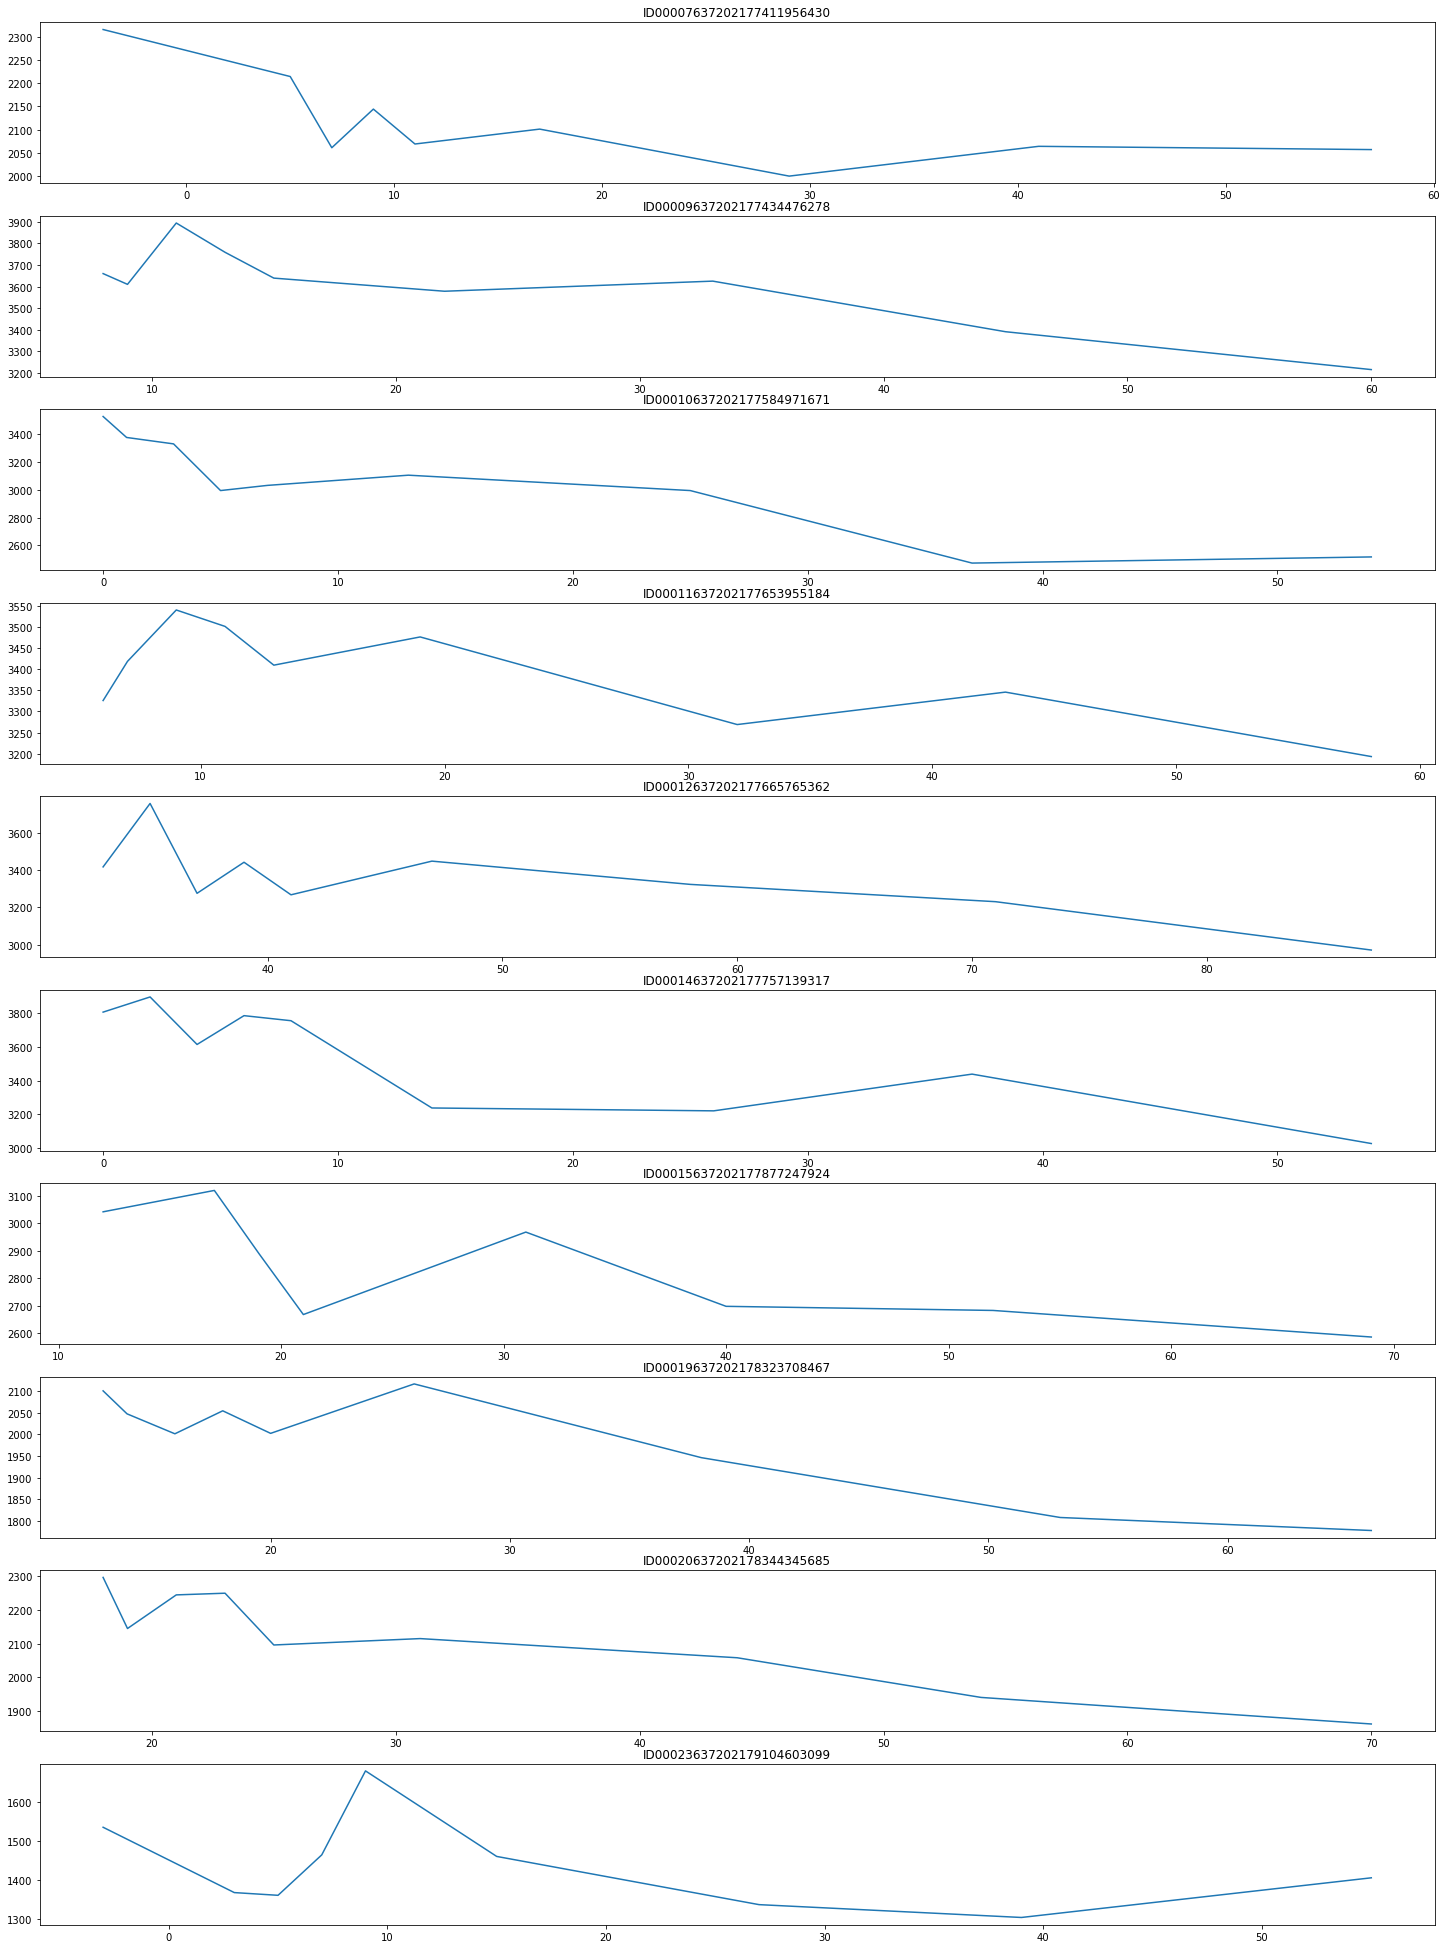

In [ ]:
fig, ax = plt.subplots(10, 1, figsize=(25, 35))

for i in range(10):
    patient_log = train[train['Patient'] == train_patients[i]]

    ax[i].set_title(train_patients[i])
    ax[i].plot(patient_log['Weeks'], patient_log['FVC'])

This code creates a figure with 10 subplots, where each subplot shows the progression of FVC (Forced Vital Capacity) over time for a specific patient in the training dataset. Here's a step-by-step breakdown of what the code is doing:

1. The `fig, ax = plt.subplots(10, 1, figsize=(25, 35))` line creates a figure object with 10 subplots stacked vertically (`10, 1`) and sets the figure size to 25 inches wide and 35 inches tall (`figsize=(25, 35)`).
2. The `for i in range(10):` line creates a loop that iterates 10 times, with `i` ranging from 0 to 9.
3. The `patient_log = train[train['Patient'] == train_patients[i]]` line selects a subset of the training data (`train`) where the "Patient" column matches the `i`th patient in the list `train_patients`. This creates a DataFrame called `patient_log` that contains only the data for the current patient.
4. The `ax[i].set_title(train_patients[i])` line sets the title of the `i`th subplot to the ID of the current patient.
5. The `ax[i].plot(patient_log['Weeks'], patient_log['FVC'])` line plots the FVC values over time for the current patient, using the "Weeks" column as the x-axis and the "FVC" column as the y-axis. The plot is added to the `i`th subplot.

Overall, this code is likely used to visualize the FVC progression over time for a sample of patients in the training dataset, giving the user a sense of how the FVC values vary between patients and over time.

So the decline is kinda linear as it does generally trend down over time. There are some spikes back up along the way which could cause a few issues. However this means that a simple linear model could have a good go at producing forecasts on this challenge as the main thing we need to do is predict the rate of decline for a patient. Like a trend line for these charts.

## Feature Engineering

There is some good scope for engineering new features for this model. 

### First FVC and First Week
Some useful features might be the first FVC recorded per patient and the week it was recorded in

In [ ]:
all_data['FirstWeek'] = all_data['Weeks']
all_data.loc[all_data.Dataset=='submission','FirstWeek'] = np.nan
all_data['FirstWeek'] = all_data.groupby('Patient')['FirstWeek'].transform('min')

In [ ]:
# GROUPING FIRSTFVC TO PATIENT ID, SORTING IT IN SCENDING ORDER, AND FINALLY MERGING BACK TO ALL_DATA

first_fvc = (
    all_data
    .loc[all_data.Weeks == all_data.FirstWeek][['Patient','FVC']]
    .rename({'FVC': 'FirstFVC'}, axis=1)
    .groupby('Patient')
    .first()
    .reset_index()
)

all_data = all_data.merge(first_fvc, on='Patient', how='left')

In [ ]:
all_data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Dataset,Confidence,Patient_Week,FirstWeek,FirstFVC
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315


### Weeks Passed
This feature measures how many weeks have passed since the patients first FVC reading.

In [ ]:
all_data['WeeksPassed'] = all_data['Weeks'] - all_data['FirstWeek']

In [ ]:
all_data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Dataset,Confidence,Patient_Week,FirstWeek,FirstFVC,WeeksPassed
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,0.0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,9.0
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,11.0
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,13.0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,15.0


### Patient height

It appears that a patient's height is a significant factor to consider when making predictions about their Forced Vital Capacity (FVC). It's possible that individuals with a taller stature may have bigger lungs and therefore be capable of exhaling more air.

**We hence looked for metrics to relate height of the patient to pulmonary functions, and found it here:**

https://en.wikipedia.org/wiki/Vital_capacity#:~:text=It%20is%20equal%20to%20the,a%20wet%20or%20regular%20spirometer

In [ ]:
def calculate_height(row):
    if row['Sex'] == 'Male':
        return row['FirstFVC'] / (27.63 - 0.112 * row['Age'])
    else:
        return row['FirstFVC'] / (21.78 - 0.101 * row['Age'])

all_data['Height'] = all_data.apply(calculate_height, axis=1)

This code defines a function `calculate_height` that calculates the estimated height of a patient based on their age, sex, and their first recorded FVC (Forced Vital Capacity) value. The function takes a single argument `row`, which represents a single row of a Pandas DataFrame that contains the patient's data.

Here's a step-by-step breakdown of what the code is doing:

1. The `if row['Sex'] == 'Male':` line checks if the patient's sex is male. If so, the function uses the following equation to estimate the patient's height:

    `height = FVC / (27.63 - 0.112 * age)`

    This equation is based on a regression model that relates FVC, age, and sex to height for male patients.

2. If the patient's sex is not male (i.e., the patient is female), the function uses the following equation to estimate the patient's height:

    `height = FVC / (21.78 - 0.101 * age)`

    This equation is based on a regression model that relates FVC, age, and sex to height for female patients.

3. The `all_data['Height'] = all_data.apply(calculate_height, axis=1)` line applies the `calculate_height` function to each row of the `all_data` DataFrame, using the `apply` method with `axis=1`. This creates a new column called "Height" in the `all_data` DataFrame, where each row contains the estimated height of the corresponding patient.

Overall, this code is likely used to estimate the height of patients in a medical dataset, using a regression model that relates FVC, age, and sex to height. The estimated height can then be used as a feature in a machine learning model to predict other medical outcomes.

In [ ]:
all_data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Dataset,Confidence,Patient_Week,FirstWeek,FirstFVC,WeeksPassed,Height
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,0.0,123.256309
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,9.0,123.256309
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,11.0,123.256309
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,13.0,123.256309
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,15.0,123.256309


### Categorical columns

The sex and smoking status columns are categorical columns that need some transformation to turn them into numbers. Pandas get dummies makes this easy to achieve.

In [ ]:
all_data = pd.concat([
    all_data,
    pd.get_dummies(all_data.Sex),
    pd.get_dummies(all_data.SmokingStatus)
], axis=1)

all_data = all_data.drop(columns=['Sex', 'SmokingStatus'])

In [ ]:
all_data.head()

,Patient,Weeks,FVC,Percent,Age,Dataset,Confidence,Patient_Week,FirstWeek,FirstFVC,WeeksPassed,Height,Female,Male,Currently smokes,Ex-smoker,Never smoked
0,ID00007637202177411956430,-4,2315,58.253649,79,train,NaN,NaN,-4.0,2315,0.0,123.256309,0,1,0,1,0
1,ID00007637202177411956430,5,2214,55.712129,79,train,NaN,NaN,-4.0,2315,9.0,123.256309,0,1,0,1,0
2,ID00007637202177411956430,7,2061,51.862104,79,train,NaN,NaN,-4.0,2315,11.0,123.256309,0,1,0,1,0
3,ID00007637202177411956430,9,2144,53.950679,79,train,NaN,NaN,-4.0,2315,13.0,123.256309,0,1,0,1,0
4,ID00007637202177411956430,11,2069,52.063412,79,train,NaN,NaN,-4.0,2315,15.0,123.256309,0,1,0,1,0


### Scale features

Now scale all the features to get them onto the same range of numbers (0-1).

In [ ]:
def scale_feature(series):
    return (series - series.min()) / (series.max() - series.min())

all_data['Weeks'] = scale_feature(all_data['Weeks'])
all_data['Percent'] = scale_feature(all_data['Percent'])
all_data['Age'] = scale_feature(all_data['Age'])
all_data['FirstWeek'] = scale_feature(all_data['FirstWeek'])
all_data['FirstFVC'] = scale_feature(all_data['FirstFVC'])
all_data['WeeksPassed'] = scale_feature(all_data['WeeksPassed'])
all_data['Height'] = scale_feature(all_data['Height'])

Specify what columns will be used as features. This is for easy filtering of the datasets later.

In [ ]:
feature_columns = [
    'Percent',
    'Age',
    'FirstWeek',
    'FirstFVC',
    'WeeksPassed',
    'Height',
    'Female',
    'Male', 
    'Currently smokes',
    'Ex-smoker',
    'Never smoked',
]

### Split dataframe

Split the data back into the three dataframes they started as.

In [ ]:
train = all_data.loc[all_data.Dataset == 'train']
test = all_data.loc[all_data.Dataset == 'test']
submission = all_data.loc[all_data.Dataset == 'submission']

And take a look at the features that will be used to train the model.

In [ ]:
train[feature_columns].head()

,Percent,Age,FirstWeek,FirstFVC,WeeksPassed,Height,Female,Male,Currently smokes,Ex-smoker,Never smoked
0,0.236393,0.769231,0.011905,0.241456,0.179012,0.211783,0,1,0,1,0
1,0.215941,0.769231,0.011905,0.241456,0.234568,0.211783,0,1,0,1,0
2,0.184960,0.769231,0.011905,0.241456,0.246914,0.211783,0,1,0,1,0
3,0.201767,0.769231,0.011905,0.241456,0.259259,0.211783,0,1,0,1,0
4,0.186580,0.769231,0.011905,0.241456,0.271605,0.211783,0,1,0,1,0


## Model

Huber Regressor is a type of robust regression algorithm used for modeling and predicting data that may contain outliers. Unlike traditional linear regression models that try to minimize the sum of squared errors, Huber Regressor minimizes a combination of squared errors for small values and absolute errors for larger ones, making it more resilient to outliers.

Huber Regressor could be useful because medical data can often have outliers or noise that could significantly impact the accuracy of predictions. By using a robust regression algorithm like Huber Regressor, the machine learning model could be more effective in capturing patterns and trends in the data, while being less sensitive to outliers that could otherwise skew the results.

In [ ]:
model = linear_model.HuberRegressor(max_iter=200)

This line of code creates an instance of the `HuberRegressor` class from scikit-learn's `linear_model` module, and assigns it to the variable `model`. 

The `HuberRegressor` is a type of linear regression model that is robust to outliers in the data, meaning that it can handle data points that deviate significantly from the rest of the data without being unduly influenced by them. It is similar to other linear regression models like `LinearRegression` or `Ridge`, but it uses a different loss function that is a combination of the mean squared error and the mean absolute error. This loss function gives less weight to data points that deviate significantly from the rest of the data, making it more robust to outliers.

The `max_iter` parameter is set to 200, which specifies the maximum number of iterations that the algorithm will perform during the optimization process. This parameter controls the maximum number of steps that the algorithm can take to find the optimal values of the model parameters (i.e., the coefficients of the linear regression equation) that minimize the loss function.

Overall, this line of code creates a `HuberRegressor` model object that can be used to fit a linear regression model to data, and sets the maximum number of iterations for the optimization algorithm to 200.

In [ ]:
model.fit(train[feature_columns], train['FVC'])

HuberRegressor(max_iter=200)

In [ ]:
predictions = model.predict(train[feature_columns])

## Evaluate

Let's begin by having a look at the models weights. This gives us a good indication of what features are driving the models predictions.

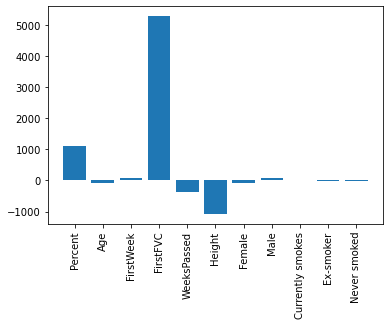

In [ ]:
plt.bar(train[feature_columns].columns.values, model.coef_)
plt.xticks(rotation=90)
plt.show()

While mean squared error isn't the competition metric it is a simple loss metric to help understand how close the models predictions are to the actual labels. The limitation of this error number though is that it can't be too close to zero as that would indicate over-fitting a model that should only be producing a trend line.

In [ ]:
mse = mean_squared_error(
    train['FVC'],
    predictions,
    squared=False
)

mae = mean_absolute_error(
    train['FVC'],
    predictions
)

print('MSE Loss: {0:.2f}'.format(mse))
print('MAE Loss: {0:.2f}'.format(mae))

MSE Loss: 177.35
MAE Loss: 128.08


This code calculates the mean squared error (MSE) and mean absolute error (MAE) between the predicted FVC values and the actual FVC values in the training data. The `mean_squared_error` and `mean_absolute_error` functions are imported from scikit-learn's `metrics` module.

Here's a step-by-step breakdown of what the code is doing:

1. The `mean_squared_error` function takes three arguments: the actual FVC values in the training data (`train['FVC']`), the predicted FVC values (`predictions`), and `squared=False` to indicate that we want to calculate the root mean squared error (RMSE) rather than the squared MSE.

2. The `mean_absolute_error` function takes the same two arguments as `mean_squared_error`: the actual FVC values in the training data and the predicted FVC values.

3. The `mse` variable is assigned the RMSE value, which is calculated by `mean_squared_error`.

4. The `mae` variable is assigned the MAE value, which is calculated by `mean_absolute_error`.

5. The `print` statements output the calculated MSE and MAE values, formatted to two decimal places using the `format` method.

Overall, this code evaluates the performance of the model by calculating the MSE and MAE between the predicted FVC values and the actual FVC values in the training data, and outputs the results to the console. This provides a measure of how well the model is fitting the training data, and can be used to compare the performance of different models or to tune the model's hyperparameters.

Found code for competition metric [here](https://www.kaggle.com/titericz/tabular-simple-eda-linear-model#Calculate-competition-metric)

Let's also include a scatterplot and histogram to see an overview of how close the predictions are to the labels.

In [ ]:
train['prediction'] = predictions

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


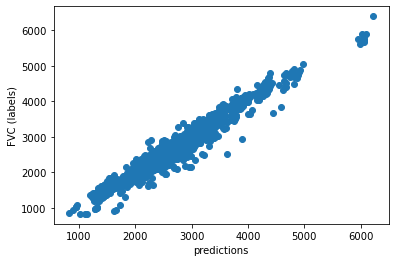

In [ ]:
plt.scatter(predictions, train['FVC'])

plt.xlabel('predictions')
plt.ylabel('FVC (labels)')
plt.show()

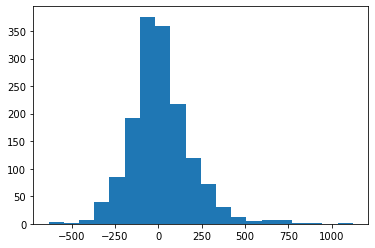

In [ ]:
delta = predictions - train['FVC']
plt.hist(delta, bins=20)
plt.show()

Finally take the first five patients as a sample and compare the true FVC readings against the models predicted FVC readings.

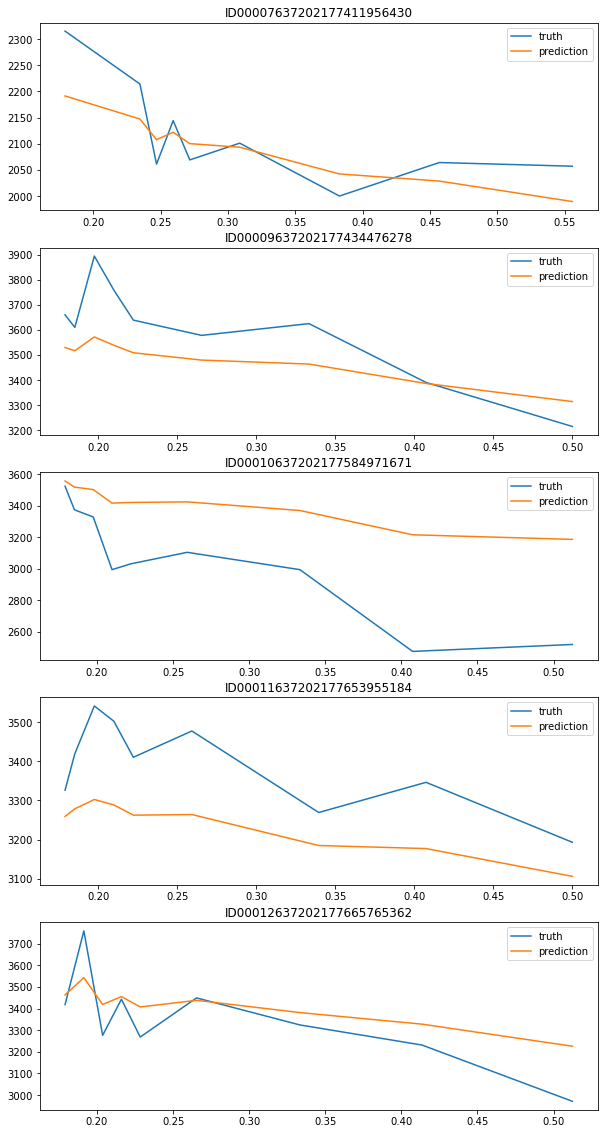

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(10, 20))

for i in range(5):
    patient_log = train[train['Patient'] == train_patients[i]]

    ax[i].set_title(train_patients[i])
    ax[i].plot(patient_log['WeeksPassed'], patient_log['FVC'], label='truth')
    ax[i].plot(patient_log['WeeksPassed'], patient_log['prediction'], label='prediction')
    ax[i].legend()

This code creates a plot with 5 subplots arranged vertically using the `subplots` function from the `matplotlib.pyplot` module, and assigns the figure object and an array of 5 axes objects to the variables `fig` and `ax`, respectively. 

Then, for each subplot, the code selects a patient from the training data using the patient ID stored in `train_patients`, and plots the actual FVC values (`patient_log['FVC']`) against the predicted FVC values (`patient_log['prediction']`) for each week passed (`patient_log['WeeksPassed']`). The `set_title` function is used to set the title of each subplot to the corresponding patient ID, and the `plot` function is used to plot the actual and predicted FVC values against the weeks passed. The `label` parameter is used to label the two lines in the plot, and the `legend` function is called to display a legend for the plot.

Overall, this code creates a plot that shows the actual and predicted FVC values for a subset of patients in the training data, which can be used to visually evaluate the performance of the model.